# Investigating EFP Components

In this notebook I want to show the two components of the EFP plotted on the same figure, with the EFP black box.

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import pandas as pd

import os
import sys
sys.path.append('/home/links/ct715/eddy_feedback/')
import functions.data_wrangling as data
import functions.plotting as plot
import functions.eddy_feedback as ef

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# Reanalysis

In [8]:
reanalysis_path = '/home/links/ct715/data_storage/reanalysis/srip_datasets'
reanalyses = ['ERA-Interim', 'JRA55', 'NCEP-NCAR']

# Create dictionary containing each model name and dataset
reanalysis_datasets = {}
for model in reanalyses:
    # create file path by joining directory and model name
    file_path = os.path.join(reanalysis_path, f'{model}_*.nc')
    # open xarray dataset
    ds = xr.open_mfdataset(file_path,
                        parallel=True, chunks={'time':31})
    # Add dataset to dictionary with required model name
    reanalysis_datasets[model] = ds 

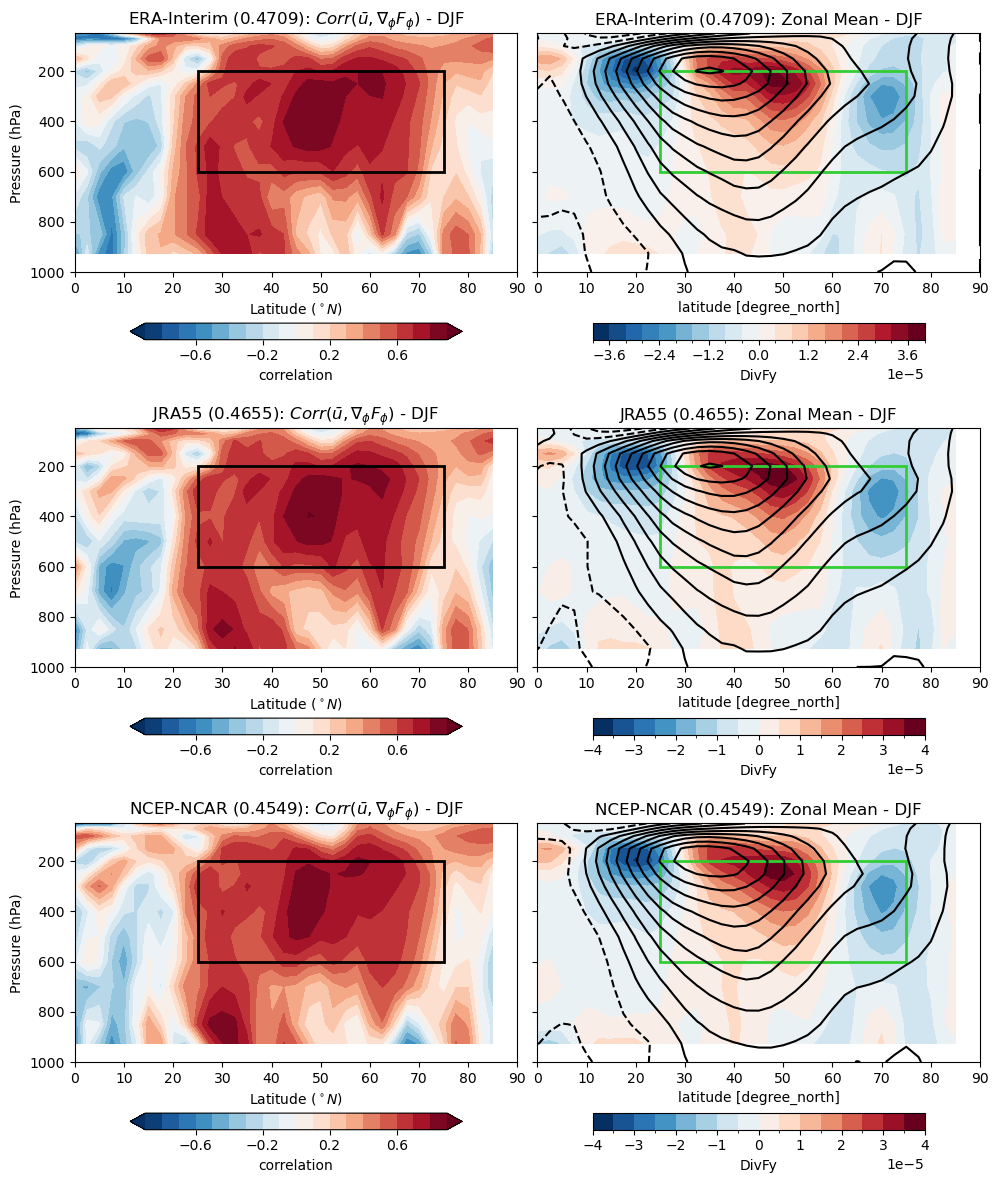

In [9]:
plot.plot_multiple_correlation_components(reanalysis_datasets, data_type='reanalysis')

# PAMIP

In [10]:
path_dir = '/home/links/ct715/data_storage/PAMIP/processed_monthly'

# extract model names
files = os.listdir(path_dir)
models = [os.path.basename(f).split('_')[0] for f in files]
models.sort()

# Create dictionary containing each model name and dataset
pamip_datasets = {}
for model in models:
    # create file path by joining directory and model name
    file_path = os.path.join(path_dir, f'{model}_*.nc')
    # open xarray dataset
    ds = xr.open_mfdataset(file_path,
                        parallel=True, chunks={'time':31})
    # Add dataset to dictionary with required model name
    pamip_datasets[model] = ds 
    
del pamip_datasets['E3SMv1']
del pamip_datasets['ECHAM6.3']

len(pamip_datasets)

13

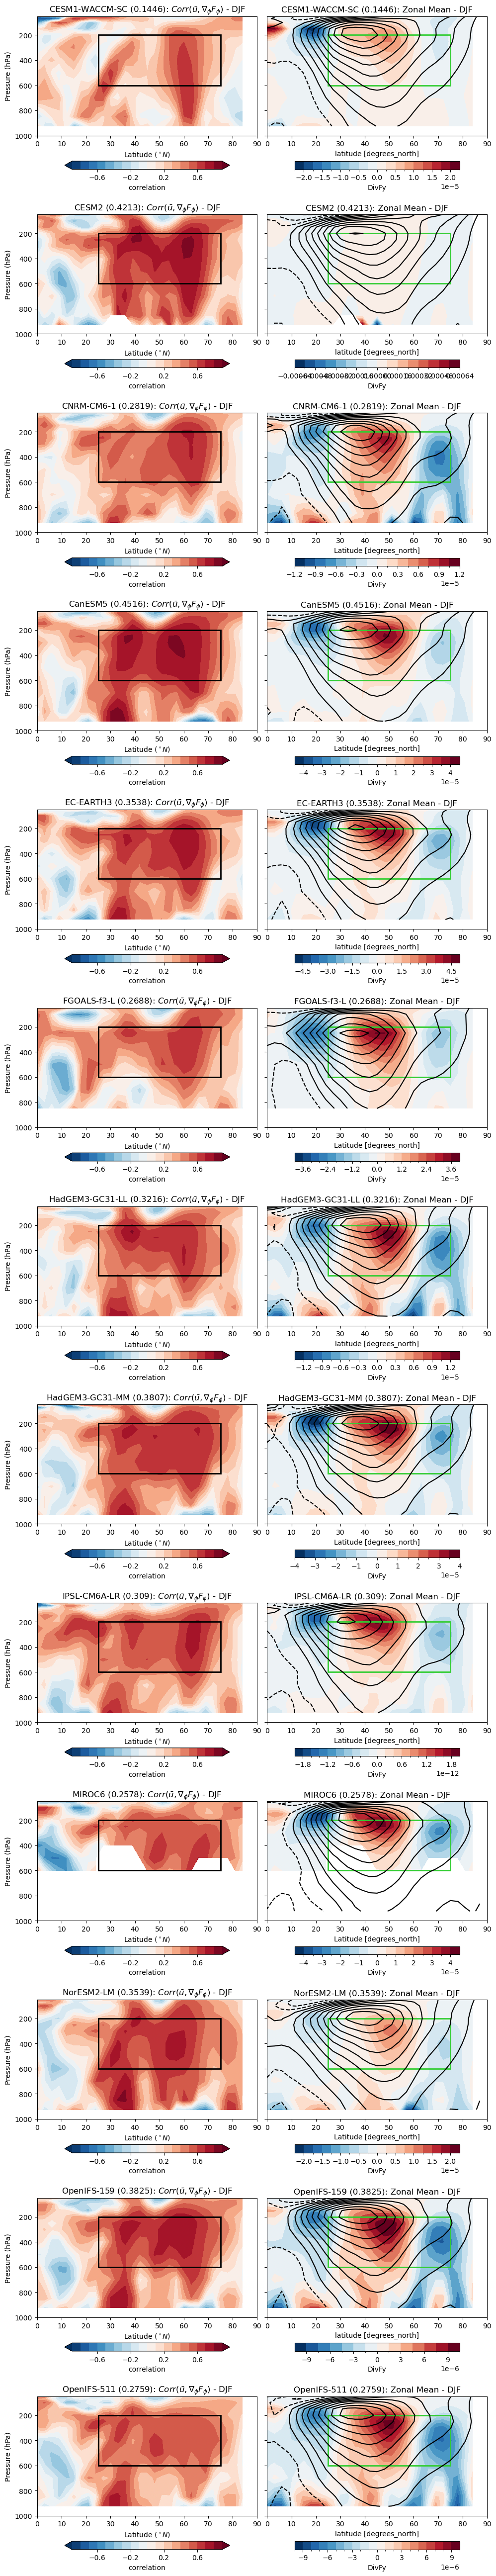

In [11]:
plot.plot_multiple_correlation_components(pamip_datasets, data_type='pamip')

### Attempting to add more columns for more datasets

In [12]:
raise ValueError

ValueError: 

In [30]:
def plot_multiple_components_reanalysis(datasets_dict, data_type=None, calc_south_hemis=False):
    """
    Plot zonal mean components for multiple datasets (only the right-hand subplot in the original function).

    Parameters:
    - datasets_dict: Dictionary of datasets to plot (keys are dataset labels, values are datasets).
    - data_type: Type of dataset ('reanalysis', 'reanalysis_qg', 'pamip', or 'isca').
    - calc_south_hemis: Whether to calculate for the Southern Hemisphere.
    """

    # Set different data types and the corresponding EP flux name
    data_type_mapping = {
        'reanalysis': 'div1_pr',
        'reanalysis_qg': 'div1_qg',
        'pamip': 'divF',
        'isca': 'div1'
    }
    if data_type not in data_type_mapping:
        raise ValueError(f'Invalid data_type: {data_type}. Expected one of {list(data_type_mapping.keys())}.')
    which_div1 = data_type_mapping.get(data_type)

    # Number of datasets
    N = len(datasets_dict)

    # Set up the figure with 1 column per dataset
    fig, axs = plt.subplots(nrows=N, ncols=1, figsize=(5, 4*N), sharey=True)

    # If there's only one dataset, axs will not be a 1D array. This fixes that.
    if N == 1:
        axs = [axs]

    # Loop over the datasets and plot for each
    for i, (label, ds) in enumerate(datasets_dict.items()):

        # Check dimensions and adjust dataset if necessary
        correct_dims = all(dim_name in ds.dims for dim_name in ['time', 'level', 'lat'])
        if not correct_dims:
            ds = data.check_dimensions(ds, ignore_dim='lon')
        ds = data.check_coords(ds)

        # Calculate Eddy Feedback Parameter (EFP)
        efp_value = ef.calculate_efp(ds, data_type=data_type, calc_south_hemis=calc_south_hemis)

        if 'ens_ax' in ds.dims:
            mean = ('time', 'ens_ax')
        else:
            mean = ('time')

        # Select latitude and level range
        if not calc_south_hemis:
            ds = ds.sel(lat=slice(0, 90))
            season = 'djf'
        else:
            ds = ds.sel(lat=slice(-90, 0))
            season = 'jas'
        ds = ds.sel(level=slice(1000, 50))

        # Right-hand subplot (mean fields)
        ax2 = axs[i]
        ds.ubar.mean(mean).plot.contour(ax=ax2, levels=20, yincrease=False, colors='k')
        ds[which_div1].mean(mean).plot.contourf(ax=ax2, levels=20, yincrease=False,
                                                cbar_kwargs={'location': 'bottom', 'shrink': 0.75, 'label': 'DivFy'})
        ax2.set_title(f'{label} ({efp_value}): Zonal Mean - {season.upper()}')

        # Plot EFP box
        rect2 = patches.Rectangle((25., 600.), 50, -400, fill=False, linewidth=2, color='limegreen')
        ax2.add_patch(rect2)

        # Remove Y-label on the right-hand subplots
        ax2.set_ylabel('')

    # Adjust layout to avoid overlapping
    plt.tight_layout()
    plt.show()


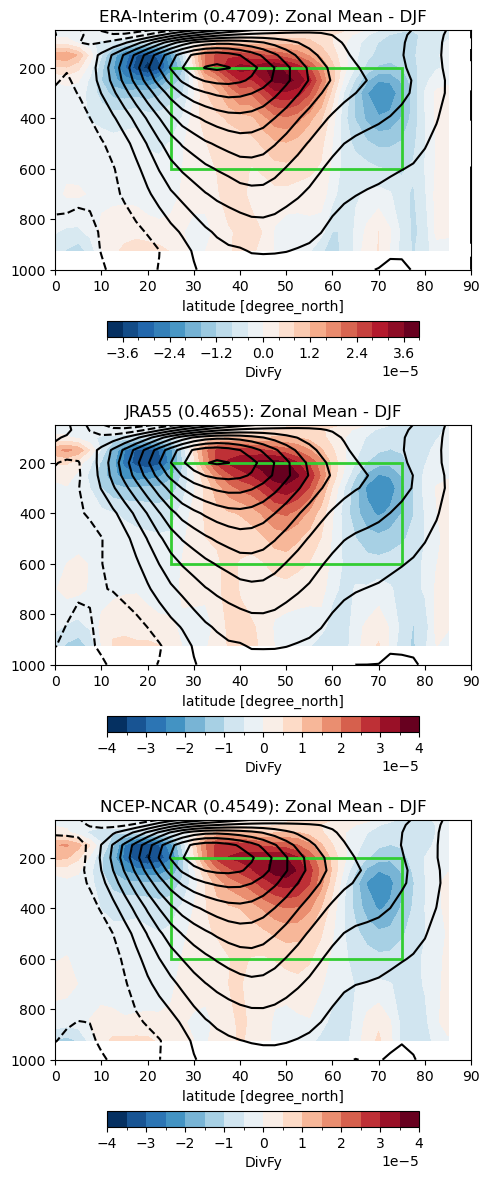

In [31]:
plot_multiple_components_reanalysis(reanalysis_datasets, data_type='reanalysis')

In [37]:
def plot_multiple_components(datasets_dict, data_type=None, calc_south_hemis=False):
    """
    Plot zonal mean components for multiple datasets in a grid with up to 3 rows per column.

    Parameters:
    - datasets_dict: Dictionary of datasets to plot (keys are dataset labels, values are datasets).
    - data_type: Type of dataset ('reanalysis', 'reanalysis_qg', 'pamip', or 'isca').
    - calc_south_hemis: Whether to calculate for the Southern Hemisphere.
    """

    # Set different data types and the corresponding EP flux name
    data_type_mapping = {
        'reanalysis': 'div1_pr',
        'reanalysis_qg': 'div1_qg',
        'pamip': 'divF',
        'isca': 'div1'
    }
    if data_type not in data_type_mapping:
        raise ValueError(f'Invalid data_type: {data_type}. Expected one of {list(data_type_mapping.keys())}.')
    which_div1 = data_type_mapping.get(data_type)

    # Number of datasets
    N = len(datasets_dict)
    
    # Determine the number of rows and columns (3 rows max per column)
    max_rows = 3
    ncols = (N // max_rows) + (N % max_rows > 0)
    nrows = min(N, max_rows)
    
    # Set up the figure with the appropriate number of rows and columns
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharey=True)

    # If there's only one subplot, axs will not be a 2D array. This fixes that.
    if N == 1:
        axs = [[axs]]
    elif N <= max_rows:
        axs = [axs]  # Convert to 2D array with 1 column
    else:
        axs = np.reshape(axs, (nrows, ncols))

    # Loop over the datasets and plot for each
    for i, (label, ds) in enumerate(datasets_dict.items()):
        row = i % max_rows
        col = i // max_rows

        # Check dimensions and adjust dataset if necessary
        correct_dims = all(dim_name in ds.dims for dim_name in ['time', 'level', 'lat'])
        if not correct_dims:
            ds = data.check_dimensions(ds, ignore_dim='lon')
        ds = data.check_coords(ds)

        # Calculate Eddy Feedback Parameter (EFP)
        efp_value = ef.calculate_efp(ds, data_type=data_type, calc_south_hemis=calc_south_hemis)

        if 'ens_ax' in ds.dims:
            mean = ('time', 'ens_ax')
        else:
            mean = ('time')

        # Select latitude and level range
        if not calc_south_hemis:
            ds = ds.sel(lat=slice(0, 90))
            season = 'djf'
        else:
            ds = ds.sel(lat=slice(-90, 0))
            season = 'jas'
        ds = ds.sel(level=slice(1000, 50))

        # Right-hand subplot (mean fields)
        ax = axs[row][col]
        ds.ubar.mean(mean).plot.contour(ax=ax, levels=20, yincrease=False, colors='k')
        ds[which_div1].mean(mean).plot.contourf(ax=ax, levels=20, yincrease=False,
                                                cbar_kwargs={'location': 'bottom', 'shrink': 0.75, 'label': 'DivFy'})
        ax.set_title(f'{label} (EFP={efp_value})')

        # Plot EFP box
        rect = patches.Rectangle((25., 600.), 50, -400, fill=False, linewidth=2, color='limegreen')
        ax.add_patch(rect)

        # Remove Y-label on the right-hand subplots
        if col > 0:
            ax.set_ylabel('')
            
    # Hide unused subplots
    total_plots = nrows * ncols
    for i in range(N, total_plots):
        row = i % max_rows
        col = i // max_rows
        axs[row][col].axis('off')  # Hide unused subplot

    # Adjust layout to avoid overlapping
    plt.tight_layout()
    plt.show()


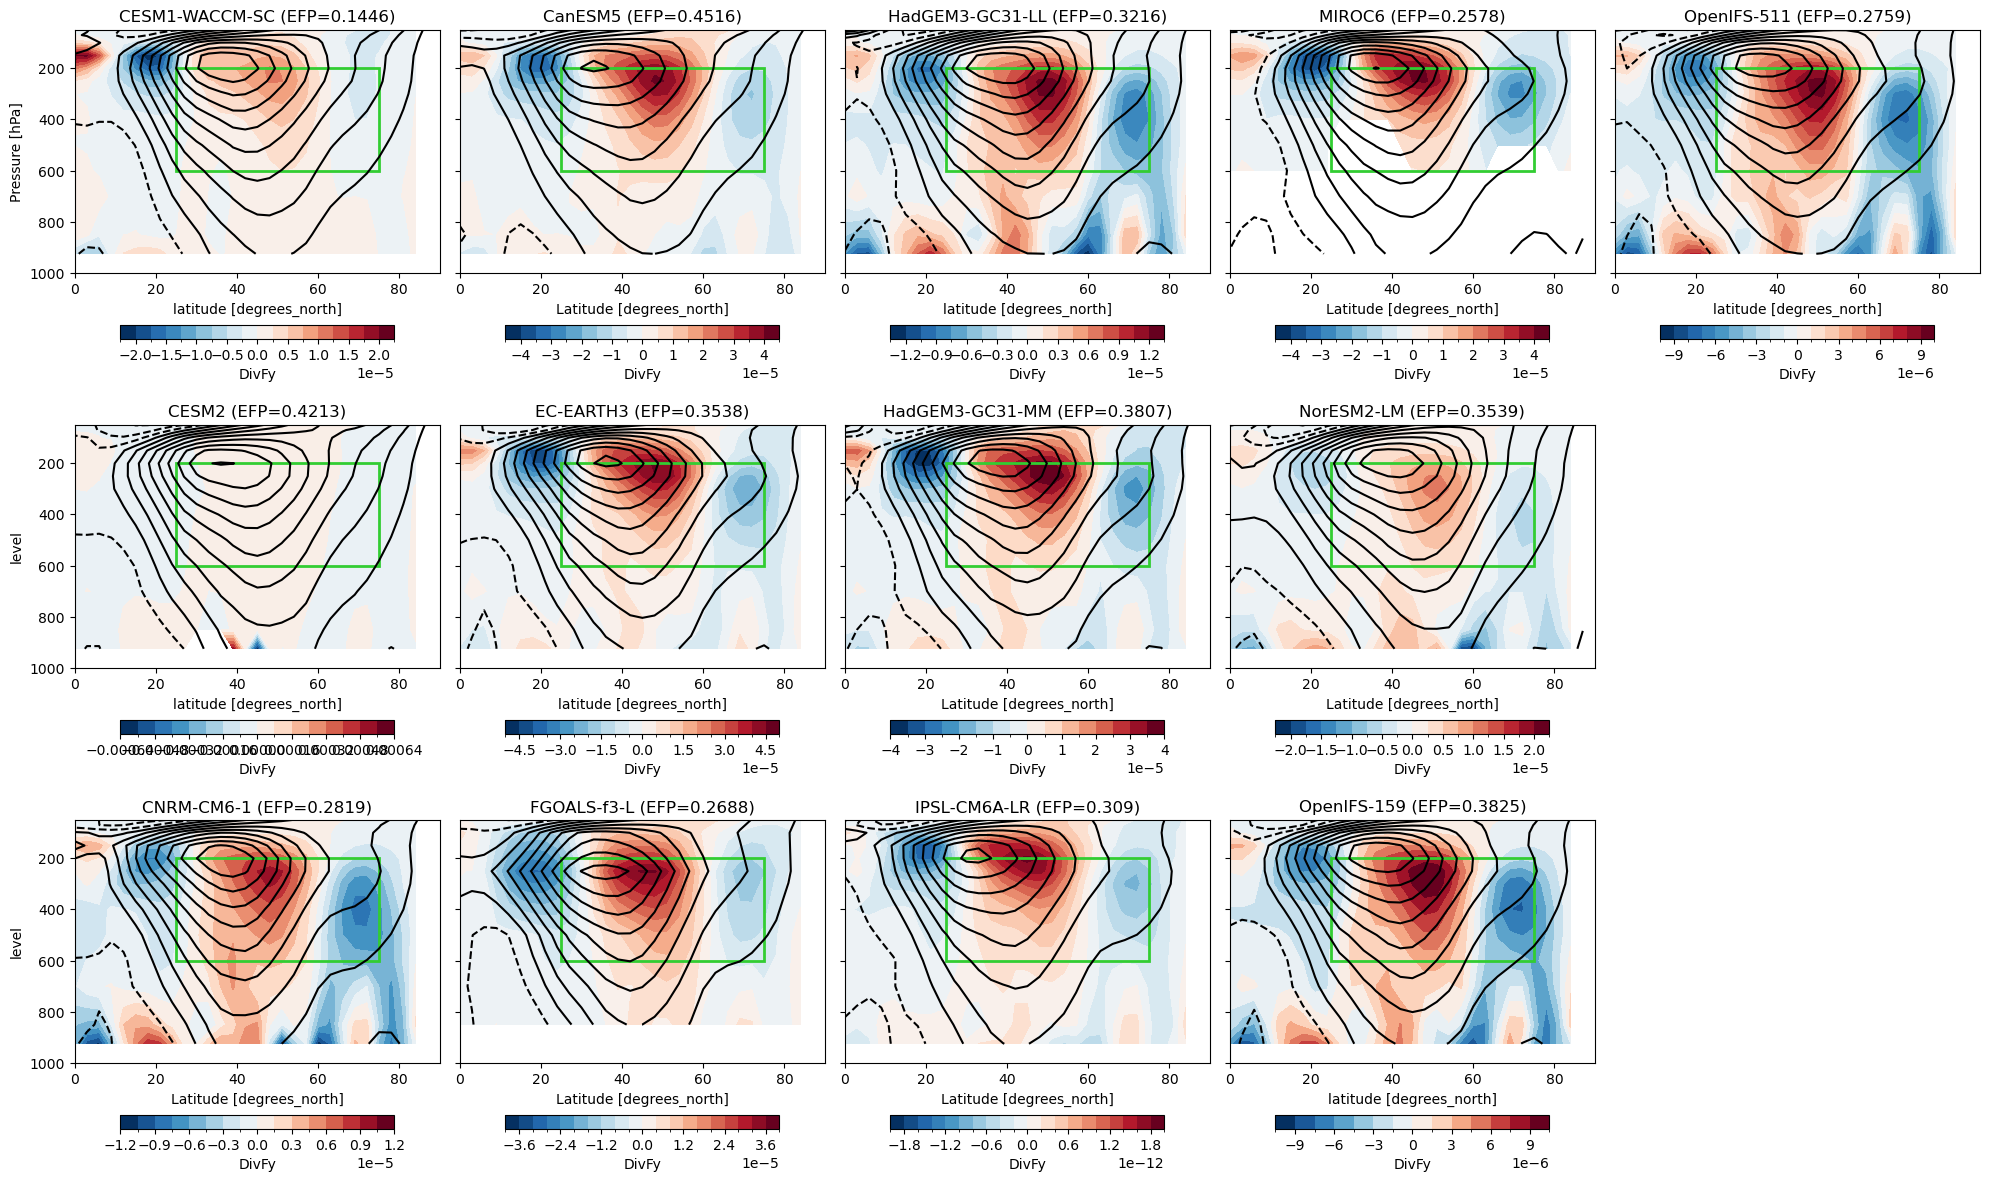

In [38]:
plot_multiple_components(pamip_datasets, data_type='pamip')